In [1]:
import torch
import torch.nn as nn
from torch.nn import Sequential as Seq,Linear,ReLU,BatchNorm1d
from torch_scatter import scatter_mean

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from InteractionNetwork import InteractionNetwork

In [2]:
import numpy

<hr>
load pretrained model

In [4]:
model=InteractionNetwork()
model.load_state_dict(torch.load("../data/model/IN_sythesized.pth"))

<All keys matched successfully>

end of load pretrained model
<hr>
get data

In [5]:
b=torch.load("../data/test_sytehsized.pt")
g=b[1]
g.batch=torch.tensor(np.zeros(g.x.shape[0]).astype("int64"))
g

Data(batch=[10], edge_index=[2, 90], x=[10, 48], y=[1, 2])

In [6]:
row,col=g.edge_index

In [7]:
g.y

tensor([[1., 0.]])

end of get data<hr>

functions copied from `src.util`

In [8]:
def copy_layer(layer):
    """
    create a deep copy of provided layer
    """
    layer_cp=eval("nn."+layer.__repr__())
    layer_cp.load_state_dict(layer.state_dict())
    
    return layer_cp

In [9]:
copy_tensor=lambda x: torch.tensor(x.clone().detach().numpy(),requires_grad=True,dtype=torch.float32)

In [10]:
L=dict()
hook_handles=[]
A=dict()
C=dict()


# def make_backward_hook(name):
#     def get_grad(grad):
#         C[name]=grad.data
        
#         return grad
#     return make_backward_hook


def make_forward_hook(name):
    def get_activations(self,inputs,outputs):
        assert len(inputs)==1
        inputs=inputs[0]
#         inputs.retain_grad()
#         hook=make_backward_hook(name)
#         hook_handles.append(inputs.register_hook(hook))
        
        A[name]=copy_tensor(inputs)
        
    return get_activations



def get_layers(name,model):
    l=list(model.named_children())
    
    if len(l)==0:
        L[name]=model
        hook=make_forward_hook(name)
        hook_handles.append(model.register_forward_hook(hook))
    else:
        l=list(model.named_children())
        for i in l:
            get_layers(name+"."+i[0],i[1])

[h.remove() for h in hook_handles]
get_layers("",model)

In [15]:
model.eval()
u,_=model.forward(g.x,g.edge_index,g.batch)
u

tensor([[ 0.5154, -0.3607]], grad_fn=<AddmmBackward>)

In [16]:
_A={}

for i,n in enumerate(A.keys()):
    print(i,n,A[n].shape)
    _A[i]=A[n]

0 .bn torch.Size([10, 48])
1 .interactionnetwork.edge_model.edge_mlp.0 torch.Size([90, 96])
2 .interactionnetwork.edge_model.edge_mlp.1 torch.Size([90, 128])
3 .interactionnetwork.edge_model.edge_mlp.2 torch.Size([90, 128])
4 .interactionnetwork.edge_model.edge_mlp.3 torch.Size([90, 128])
5 .interactionnetwork.node_model.node_mlp_1.0 torch.Size([90, 176])
6 .interactionnetwork.node_model.node_mlp_1.1 torch.Size([90, 128])
7 .interactionnetwork.node_model.node_mlp_1.2 torch.Size([90, 128])
8 .interactionnetwork.node_model.node_mlp_1.3 torch.Size([90, 128])
9 .interactionnetwork.node_model.node_mlp_2.0 torch.Size([10, 176])
10 .interactionnetwork.node_model.node_mlp_2.1 torch.Size([10, 128])
11 .interactionnetwork.node_model.node_mlp_2.2 torch.Size([10, 128])
12 .interactionnetwork.node_model.node_mlp_2.3 torch.Size([10, 128])
13 .interactionnetwork.global_model.global_mlp.0 torch.Size([1, 128])
14 .interactionnetwork.global_model.global_mlp.1 torch.Size([1, 128])
15 .interactionnetwork.

In [18]:
pred=nn.Softmax(dim=1)(u)
r={}
# r[17]=copy_tensor(pred)
r[17]=copy_tensor(u*torch.tensor([0,1],dtype=torch.float32))
r[17]

tensor([[ 0.0000, -0.3607]], requires_grad=True)

In [19]:
a=copy_tensor(_A[16])
a.retain_grad()
layer=L[".interactionnetwork.global_model.global_mlp.3"]

z=layer.forward(a)
s=r[17]/(z+1e-9)

(z*s.data).sum().backward()

c=a.grad
r[16]=a*c

In [20]:
r[16].sum()

tensor(-0.0253, grad_fn=<SumBackward0>)

In [25]:
a=copy_tensor(_A[15])
a.retain_grad()
layer=L[".interactionnetwork.global_model.global_mlp.2"]

z=layer.forward(a)
s=r[16]/(z+1e-9)

(z*s.data).sum().backward()

c=a.grad
r[15]=a*c

In [26]:
r[15].sum()

tensor(-0.0253, grad_fn=<SumBackward0>)

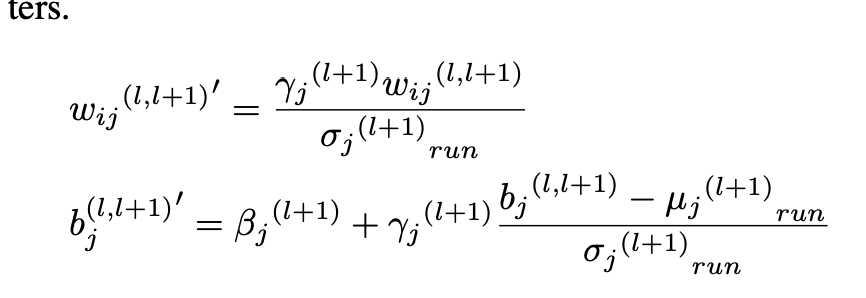

In [27]:
# w=copy_tensor(L[".interactionnetwork.global_model.global_mlp.0"].weight.data)
# b=copy_tensor(L[".interactionnetwork.global_model.global_mlp.0"].bias.data)

# gamma=copy_tensor(L[".interactionnetwork.global_model.global_mlp.1"].weight.data)
# beta=copy_tensor(L[".interactionnetwork.global_model.global_mlp.1"].bias.data)

# sigma=copy_tensor(((L[".interactionnetwork.global_model.global_mlp.1"].running_var+1e-5)**0.5).data)
# miu=copy_tensor((L[".interactionnetwork.global_model.global_mlp.1"].running_mean).data)

# layer=Linear(in_features=128,out_features=128)
# state=layer.state_dict()

# state["weight"]=copy_tensor(
#     (w.T*gamma/sigma).T
# ).data
# state["bias"]=copy_tensor(beta+gamma*(b-miu)/sigma).data

# layer.load_state_dict(state)


# a=copy_tensor(A[".interactionnetwork.global_model.global_mlp.0"].data)
# a.retain_grad()

# z=layer.forward(a)
# s=r[15]/(z+1e-9)

# (z*s.data).sum().backward()

# c=a.grad

# r[13]=a*c
# (r[13]).sum()

|z|-rule for batchnorm layer

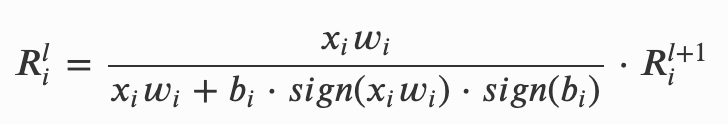

In [28]:
def f(X,Rk):
    Ri=torch.zeros(*X.shape)
    for i in range(X.shape[0]):
        x=X[i,:]
        n=x*w
        d=x*w+torch.abs(b)*torch.sign(x*w)
        Ri[i,:]=(n/d)*Rk[i,:]
        
    return Ri

w=copy_tensor(L[".interactionnetwork.global_model.global_mlp.1"].weight.data)
b=copy_tensor(L[".interactionnetwork.global_model.global_mlp.1"].bias.data)
a=copy_tensor(A[".interactionnetwork.global_model.global_mlp.1"].data)

result=f(a,r[15])
result.sum()

tensor(-0.0231, grad_fn=<SumBackward0>)

In [29]:
w=copy_tensor(L[".interactionnetwork.global_model.global_mlp.1"].weight.data)
b=copy_tensor(L[".interactionnetwork.global_model.global_mlp.1"].bias.data)


def f(x):
    x.retain_grad()
    
    n=x*w
    d=n+b*torch.sign(n)*torch.sign(b)
    
    return n/d


a=copy_tensor(A[".interactionnetwork.global_model.global_mlp.1"].data)
frac=f(a)
r[14]=frac*r[15]

print(r[14].sum())




a=copy_tensor(A[".interactionnetwork.global_model.global_mlp.0"])
a.retain_grad()
layer=L[".interactionnetwork.global_model.global_mlp.0"]

z=layer.forward(a)
s=r[14]/(z+1e-9)

(z*s.data).sum().backward()

c=a.grad
r[13]=a*c

print(r[13].sum())

tensor(-0.0231, grad_fn=<SumBackward0>)
tensor(-0.0232, grad_fn=<SumBackward0>)


In [30]:
n_tracks=g.x.shape[0]
r_scatter=r[13].repeat(n_tracks,1)/n_tracks
r_scatter.sum()

tensor(-0.0232, grad_fn=<SumBackward0>)

In [31]:
n_tracks=g.x.shape[0]
r_scatter=r[13].repeat(n_tracks,1)/n_tracks

a=copy_tensor(A[".interactionnetwork.node_model.node_mlp_2.3"])
a.retain_grad()
layer=L[".interactionnetwork.node_model.node_mlp_2.3"]

z=layer.forward(a)
s=r_scatter/(z+1e-9)

(z*s.data).sum().backward()

c=a.grad
r[12]=a*c

In [32]:
a=copy_tensor(A[".interactionnetwork.node_model.node_mlp_2.2"])
a.retain_grad()
layer=L[".interactionnetwork.node_model.node_mlp_2.2"]

z=layer.forward(a)
s=r[12]/(z+1e-9)

(z*s.data).sum().backward()

c=a.grad
r[11]=a*c

In [33]:
# w=copy_tensor(L[".interactionnetwork.node_model.node_mlp_2.0"].weight.data)
# b=copy_tensor(L[".interactionnetwork.node_model.node_mlp_2.0"].bias.data)

# gamma=copy_tensor(L[".interactionnetwork.node_model.node_mlp_2.1"].weight.data)
# beta=copy_tensor(L[".interactionnetwork.node_model.node_mlp_2.1"].bias.data)

# sigma=copy_tensor(((L[".interactionnetwork.node_model.node_mlp_2.1"].running_var+1e-5)**0.5).data)
# miu=copy_tensor((L[".interactionnetwork.node_model.node_mlp_2.1"].running_mean).data)

# layer=Linear(in_features=48+128,out_features=128)
# state=layer.state_dict()
# state["weight"]=copy_tensor(
#     (w.T*gamma/sigma).T
# ).data
# state["bias"]=copy_tensor(beta+gamma*(b-miu)/sigma).data
# layer.load_state_dict(state)


# a=copy_tensor(A[".interactionnetwork.node_model.node_mlp_2.0"].data)
# a.retain_grad()

# z=layer.forward(a)
# s=r[11]/(z+1e-9)

# (z*s.data).sum().backward()

# c=a.grad

# r[10]=a*c
# (r[10]).sum()

In [34]:
w=copy_tensor(L[".interactionnetwork.node_model.node_mlp_2.1"].weight.data)
b=copy_tensor(L[".interactionnetwork.node_model.node_mlp_2.1"].bias.data)


def f(x):
    x.retain_grad()
    
    n=x*w
    d=n+b*torch.sign(n)*torch.sign(b)
    
    return n/d


a=copy_tensor(A[".interactionnetwork.node_model.node_mlp_2.1"].data)
frac=f(a)
r[10]=frac*r[11]

print(r[10].sum())




a=copy_tensor(A[".interactionnetwork.node_model.node_mlp_2.0"])
a.retain_grad()
layer=L[".interactionnetwork.node_model.node_mlp_2.0"]

z=layer.forward(a)
s=r[10]/(z+1e-9)

(z*s.data).sum().backward()

c=a.grad
r[9]=a*c

print(r[9].sum())

tensor(-0.0257, grad_fn=<SumBackward0>)
tensor(-0.0256, grad_fn=<SumBackward0>)


In [35]:
# r split to two paths
r_x,r_=r[9][:,:48],r[9][:,48:]
r_=r_[col]/(n_tracks-1)
print(r_.sum(),r_x.sum())

a=copy_tensor(A[".interactionnetwork.node_model.node_mlp_1.3"])
a.retain_grad()
layer=L[".interactionnetwork.node_model.node_mlp_1.3"]

z=layer.forward(a)
s=r_/(z+1e-9)

(z*s.data).sum().backward()

c=a.grad
r[8]=a*c

print(r[8].sum())

tensor(-0.0240, grad_fn=<SumBackward0>) tensor(-0.0016, grad_fn=<SumBackward0>)
tensor(-0.0239, grad_fn=<SumBackward0>)


In [36]:
a=copy_tensor(A[".interactionnetwork.node_model.node_mlp_1.2"])
a.retain_grad()
layer=L[".interactionnetwork.node_model.node_mlp_1.2"]

z=layer.forward(a)
s=r[8]/(z+1e-9)

(z*s.data).sum().backward()

c=a.grad
r[7]=a*c

In [37]:
# w=copy_tensor(L[".interactionnetwork.node_model.node_mlp_1.0"].weight.data)
# b=copy_tensor(L[".interactionnetwork.node_model.node_mlp_1.0"].bias.data)

# gamma=copy_tensor(L[".interactionnetwork.node_model.node_mlp_1.1"].weight.data)
# beta=copy_tensor(L[".interactionnetwork.node_model.node_mlp_1.1"].bias.data)

# sigma=copy_tensor(((L[".interactionnetwork.node_model.node_mlp_1.1"].running_var+1e-5)**0.5).data)
# miu=copy_tensor((L[".interactionnetwork.node_model.node_mlp_1.1"].running_mean).data)

# layer=Linear(in_features=48+128,out_features=128)
# state=layer.state_dict()
# state["weight"]=copy_tensor(
#     (w.T*gamma/sigma).T
# ).data
# state["bias"]=copy_tensor(beta+gamma*(b-miu)/sigma).data
# layer.load_state_dict(state)


# a=copy_tensor(A[".interactionnetwork.node_model.node_mlp_1.0"].data)
# a.retain_grad()

# z=layer.forward(a)
# s=r[7]/(z+1e-9)

# (z*s.data).sum().backward()

# c=a.grad

# r[6]=a*c

In [38]:
w=copy_tensor(L[".interactionnetwork.node_model.node_mlp_1.1"].weight.data)
b=copy_tensor(L[".interactionnetwork.node_model.node_mlp_1.1"].bias.data)


def f(x):
    x.retain_grad()
    
    n=x*w
    d=n+b*torch.sign(n)*torch.sign(b)
    
    return n/d


a=copy_tensor(A[".interactionnetwork.node_model.node_mlp_1.1"].data)
frac=f(a)
r[6]=frac*r[7]

print(r[6].sum())




a=copy_tensor(A[".interactionnetwork.node_model.node_mlp_1.0"])
a.retain_grad()
layer=L[".interactionnetwork.node_model.node_mlp_1.0"]

z=layer.forward(a)
s=r[6]/(z+1e-9)

(z*s.data).sum().backward()

c=a.grad
r[5]=a*c

print(r[5].sum())

tensor(-0.0262, grad_fn=<SumBackward0>)
tensor(-0.0256, grad_fn=<SumBackward0>)


In [39]:
# r split to two paths
r_x_row,r_=r[5][:,:48],r[5][:,48:]
print(r_.sum(),r_x_row.sum())

a=copy_tensor(A[".interactionnetwork.edge_model.edge_mlp.3"])
a.retain_grad()
layer=L[".interactionnetwork.edge_model.edge_mlp.3"]

z=layer.forward(a)
s=r_/(z+1e-9)

(z*s.data).sum().backward()

c=a.grad
r[4]=a*c

print(r[4].sum())

tensor(-0.0270, grad_fn=<SumBackward0>) tensor(0.0014, grad_fn=<SumBackward0>)
tensor(-0.0275, grad_fn=<SumBackward0>)


In [40]:
a=copy_tensor(A[".interactionnetwork.edge_model.edge_mlp.2"])
a.retain_grad()
layer=L[".interactionnetwork.edge_model.edge_mlp.2"]

z=layer.forward(a)
s=r[4]/(z+1e-9)

(z*s.data).sum().backward()

c=a.grad
r[3]=a*c

print(r[3].sum())

tensor(-0.0275, grad_fn=<SumBackward0>)


In [41]:
w=copy_tensor(L[".interactionnetwork.edge_model.edge_mlp.1"].weight.data)
b=copy_tensor(L[".interactionnetwork.edge_model.edge_mlp.1"].bias.data)


def f(x):
    x.retain_grad()
    
    n=x*w
    d=n+b*torch.sign(n)*torch.sign(b)
    
    return n/d


a=copy_tensor(A[".interactionnetwork.edge_model.edge_mlp.1"].data)
frac=f(a)
r[2]=frac*r[3]

print(r[2].sum())




a=copy_tensor(A[".interactionnetwork.edge_model.edge_mlp.0"])
a.retain_grad()
layer=L[".interactionnetwork.edge_model.edge_mlp.0"]

z=layer.forward(a)
s=r[2]/(z+1e-9)

(z*s.data).sum().backward()

c=a.grad
r[1]=a*c

print(r[1].sum())

tensor(-0.0373, grad_fn=<SumBackward0>)
tensor(-0.0382, grad_fn=<SumBackward0>)


In [42]:
r_src,r_dest=r[1][:,:48],r[1][:,48:]
r_x_src=scatter_mean(r_src,row,dim=0,dim_size=g.x.shape[0])
r_x_dest=scatter_mean(r_dest,col,dim=0,dim_size=g.x.shape[0])

w=copy_tensor(L[".bn"].weight.data)
b=copy_tensor(L[".bn"].bias.data)


def f(x):
    x.retain_grad()
    
    n=x*w
    d=n+b*torch.sign(n)*torch.sign(b)+1e-10
    
    return n/d


a=copy_tensor(A[".bn"].data)
frac=f(a)
r[0]=frac*(r_x_src+r_x_dest+r_x+scatter_mean(r_x_row,row,dim=0,dim_size=g.x.shape[0])+1e-10)
print(r[0].sum())

tensor(-0.0055, grad_fn=<SumBackward0>)


In [43]:
for i in range(17,0-1,-1):
    try:
        print(i,r[i].sum().data)
    except:
        continue

17 tensor(-0.3607)
16 tensor(-0.0253)
15 tensor(-0.0253)
14 tensor(-0.0231)
13 tensor(-0.0232)
12 tensor(-0.0263)
11 tensor(-0.0263)
10 tensor(-0.0257)
9 tensor(-0.0256)
8 tensor(-0.0239)
7 tensor(-0.0239)
6 tensor(-0.0262)
5 tensor(-0.0256)
4 tensor(-0.0275)
3 tensor(-0.0275)
2 tensor(-0.0373)
1 tensor(-0.0382)
0 tensor(-0.0055)


<hr>

## Plot

In [44]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [45]:
sns.set(style="white")

In [46]:
sort_pt_idx=torch.argsort(g.x[:,0])

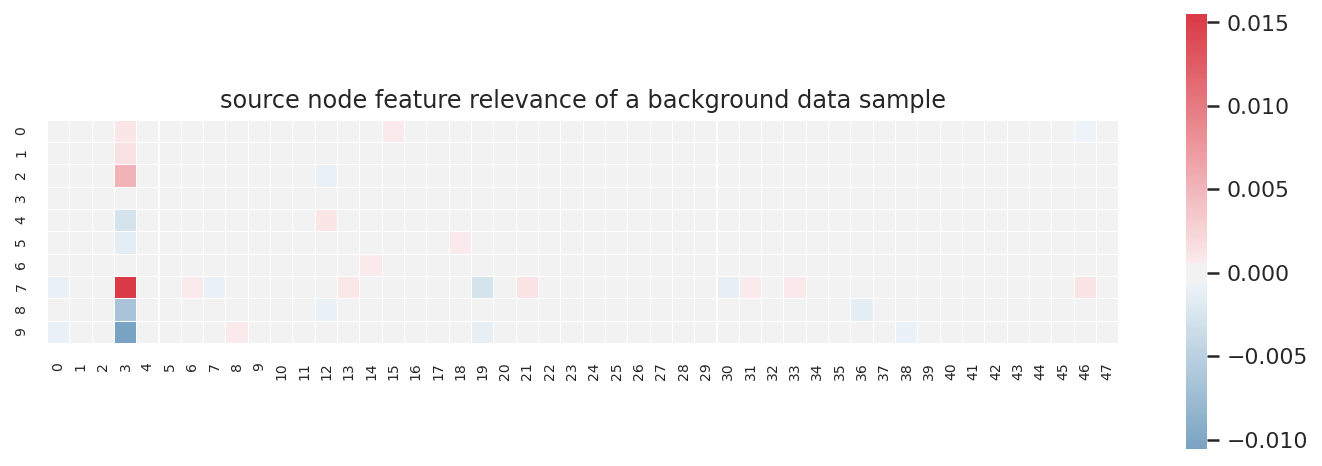

In [49]:
val=r[0].detach().cpu().numpy()
df=pd.DataFrame(val,columns=np.arange(48))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12,8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(240, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
s=sns.heatmap(df, cmap=cmap, center=0,xticklabels=1,
            square=True, linewidths=0.01, cbar_kws={"shrink": .5})

s.tick_params(labelsize=7)

if g.y[:,1]>0:
    plt.title("source node feature relevance of a signal data sample")
else:
    plt.title("source node feature relevance of a background data sample")

plt.show()